In [ ]:
import numpy as np
import cv2 
import math
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageDraw
from shapely.geometry import Point
from shapely.geometry import Polygon

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pano_image1 = cv2.imread("/content/drive/MyDrive/Assignment2_CV/shanghai-21.png") 
pano_image2 = cv2.imread("/content/drive/MyDrive/Assignment2_CV/shanghai-22.png")

First images


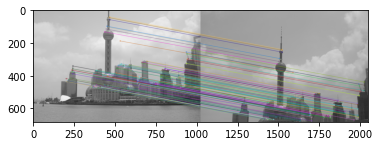

(<matplotlib.image.AxesImage at 0x7f252d641450>, None)

In [ ]:
pano_image1_grey = cv2.cvtColor(pano_image1, cv2.COLOR_BGR2GRAY)
pano_image2_grey = cv2.cvtColor(pano_image2, cv2.COLOR_BGR2GRAY)

#sift
sift = cv2.xfeatures2d.SIFT_create()

keypoints_img1, descriptors_img1 = sift.detectAndCompute(pano_image1_grey,None)
keypoints_img2, descriptors_img2 = sift.detectAndCompute(pano_image2_grey,None)

#feature matching
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors_img1,descriptors_img2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.27*n.distance:
        good.append([m])

# cv2.drawMatchesKnn expects list of lists as matches.
out_good_matches = cv2.drawMatchesKnn(pano_image1_grey,keypoints_img1,pano_image2_grey,keypoints_img2,good,pano_image2_grey,flags=2)

print("First images")
plt.imshow(out_good_matches),plt.show()

In [ ]:
def Compute_H(random_corr):
  A = []
  for corr in random_corr:
     x1 = corr[0]
     y1 = corr[1]
     x2 = corr[2]
     y2 = corr[3]
     a1 = [-x1,-y1, -1, 0, 0, 0, x1*x2, y1*x2, x2]
     a2 = [0, 0, 0, -x1,-y1, -1, x1*y2, y1*y2, y2]
     A.append(a1)
     A.append(a2)
 
  A = np.matrix(A)

  #SVD
  _, _, V  = np.linalg.svd(A)
  H = np.reshape(V[8], (3,3))
  
  H = np.divide(H,H[2,2])
  return H

In [ ]:
def getDistance(correspondence,H):

  xy = np.transpose(np.matrix([correspondence[0],correspondence[1],1]))
  xy_dash_estimated = np.dot(H,xy)
  xy_dash_estimated = np.divide(xy_dash_estimated,xy_dash_estimated[2,0])

  xy_dash = np.transpose(np.matrix([correspondence[2],correspondence[3],1]))
  error = np.linalg.norm(xy_dash_estimated - xy_dash)

  return error 

In [ ]:
def RANSAC(correspondences , threshold):
  max_inliers = []
  final_H = None
  err_threshold = 5
  for i in range(10000):

    first_corr = correspondences[random.randrange(0,len(correspondences))]
    second_corr = correspondences[random.randrange(0,len(correspondences))]
    third_corr = correspondences[random.randrange(0,len(correspondences))]
    forth_corr = correspondences[random.randrange(0,len(correspondences))]
    random_corr = np.array([first_corr,second_corr,third_corr,forth_corr])

    H = Compute_H(random_corr);

    inliers=[]
    for i in range(len(correspondences)):
       error = getDistance(correspondences[i],H)
       if error <= err_threshold:
          inliers.append(correspondences[i])

    if len(inliers) > len(max_inliers):
      max_inliers = inliers
      final_H = H

    if (len(max_inliers)/len(correspondences)) > threshold:
      break;

  if(len(max_inliers)!=0):
    final_H = Compute_H(max_inliers)
  return final_H , max_inliers

In [ ]:
correspondenceList = []
for m in good:
  (x1, y1) = keypoints_img1[m[0].queryIdx].pt
  (x2, y2) = keypoints_img2[m[0].trainIdx].pt
  correspondenceList.append([x1, y1, x2, y2])

correspondences = np.matrix(correspondenceList)
H , inliers = RANSAC(correspondenceList,0.7)

In [ ]:
def warpImage(H,img):
  
  #in this new img we will apply homography matrix and put first image components here 
  imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  min_x = 0
  min_y = 0
  max_x = 0
  max_y = 0
  correspondingPixels = []
  for i in range (imgRGB.shape[0]):
    for j in range (imgRGB.shape[1]):#for every pixel in pixels
      corr_pixel = np.dot(H,np.transpose(np.matrix(np.array([j,i,1]))))
      corr_pixel = np.array(corr_pixel.ravel()).ravel()
      corr_pixel = np.divide(corr_pixel,corr_pixel[2])
      correspondingPixels.append([round(corr_pixel[0]),round(corr_pixel[1])])
      if round(corr_pixel[0]) < min_x:
        min_x = round(corr_pixel[0]) 
      if round(corr_pixel[0]) > max_x:
        max_x = round(corr_pixel[0])
      if round(corr_pixel[1]) < min_y:
        min_y = round(corr_pixel[1])   
      if round(corr_pixel[1]) > max_y:
        max_y = round(corr_pixel[1])
  #here we should create output image
  #we should normalize values of places in the new array to start from 0,0 as no negative is applied in pixels
  min = np.array([min_x,min_y])
  max = np.array([max_x,max_y])
  #Normalized data= ( data- min(data) )/( max(data)-min(data) )
  normalizedData = np.subtract(np.array(correspondingPixels),min)
 
  out_shape = [np.abs(max_y - min_y)+1,np.abs(max_x - min_x)+1]
  new_img = np.zeros((out_shape[0],out_shape[1],3))
  red_channel = np.zeros((out_shape[0],out_shape[1]), dtype=np.uint8)
  green_channel = np.zeros((out_shape[0],out_shape[1]),  dtype=np.uint8)
  blue_channel = np.zeros((out_shape[0],out_shape[1]),  dtype=np.uint8)        
  #merging those three channels to form output channel
  count =0
  for i in range (imgRGB.shape[0]):
    for j in range (imgRGB.shape[1]):#for every pixel in pixels 
      x= normalizedData[count][0]
      y= normalizedData[count][1]
      red_channel[y][x]=imgRGB[i][j][0]
      green_channel[y][x]=imgRGB[i][j][1]
      blue_channel[y][x]=imgRGB[i][j][2]
      count += 1

  new_img = cv2.merge([blue_channel,green_channel,red_channel])  
  #max , min are returned to help in returning back to original image
  return new_img,min

In [ ]:
pano_image1_warp,min = warpImage(H,pano_image1)

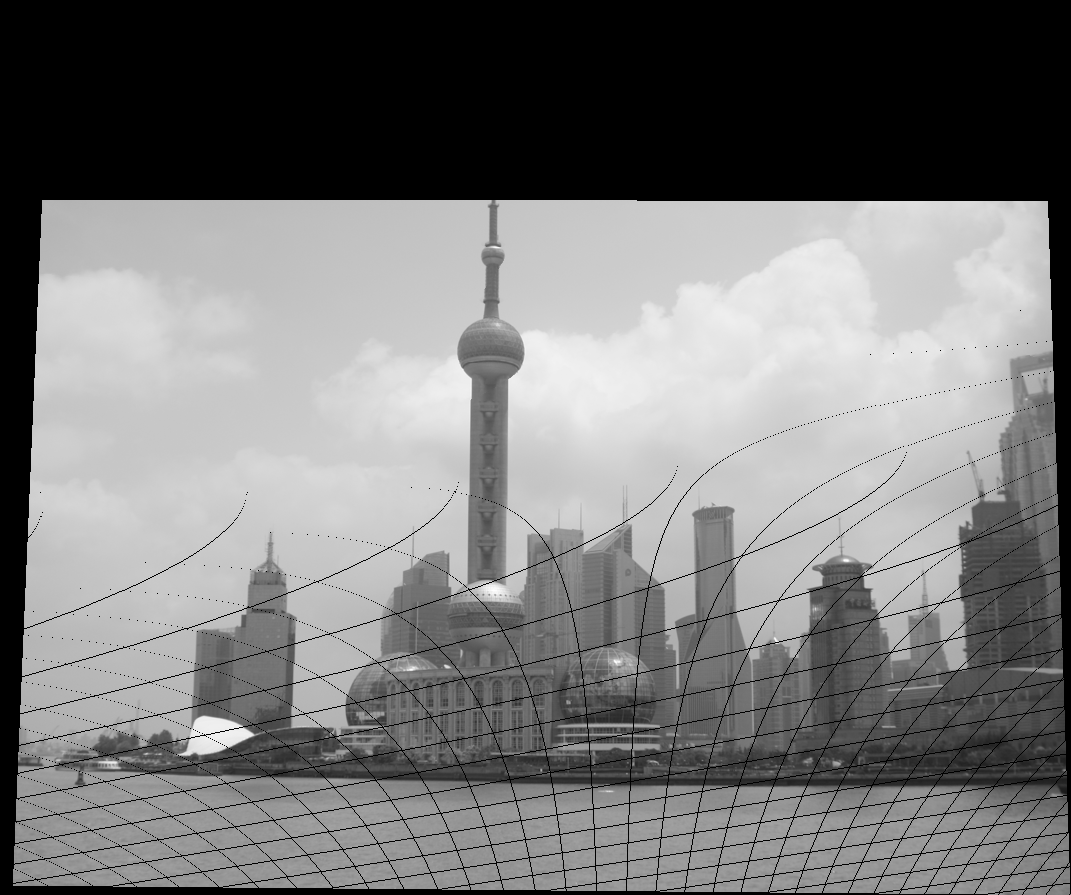

In [ ]:
cv2_imshow(pano_image1_warp)

In [ ]:
#for every pixel in the source image use it to go to final image if it wen to fractions get boundary box 
#Homography matrix inverse can help to go back to original image
def inverse_warp(img_rotate,H,img_in_shape,img_in,min):
 
  img_1 = img_rotate.copy()
  #imgRGB = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
  for i in range (img_1.shape[0]):
      for j in range (img_1.shape[1]):#for every pixel in pixels      
        corner_pixel = np.dot(np.linalg.inv(H),np.array([j+min[0],i+min[1],1]))
        corner_pixel = np.array(corner_pixel.ravel()).ravel()
        corner_pixel = np.divide(corner_pixel,corner_pixel[2])
        #if it leads to decimal get bounding box to get its color
        pts_box = set()
        if math.ceil(corner_pixel[0])>=0 and math.ceil(corner_pixel[1])>=0 and math.ceil(corner_pixel[0])<img_in_shape[1] and math.ceil(corner_pixel[1])<img_in_shape[0]:
          pts_box.add(tuple([math.ceil(corner_pixel[0]),math.ceil(corner_pixel[1])]))

        if math.floor(corner_pixel[0])>=0 and math.floor(corner_pixel[1])>=0 and math.floor(corner_pixel[0])<img_in_shape[1] and math.floor(corner_pixel[1])<img_in_shape[0]:
          pts_box.add(tuple([math.floor(corner_pixel[0]),math.floor(corner_pixel[1])]))

        if math.ceil(corner_pixel[0])>=0 and math.floor(corner_pixel[1])>=0 and math.ceil(corner_pixel[0])<img_in_shape[1] and math.floor(corner_pixel[1])<img_in_shape[0]:
          pts_box.add(tuple([math.ceil(corner_pixel[0]),math.floor(corner_pixel[1])]))

        if math.floor(corner_pixel[0])>=0 and math.ceil(corner_pixel[1])>=0 and math.ceil(corner_pixel[1])<img_in_shape[0] and math.floor(corner_pixel[0])<img_in_shape[1]:
          pts_box.add(tuple([math.floor(corner_pixel[0]),math.ceil(corner_pixel[1])]))

        red_color = 0
        green_color = 0
        blue_color = 0
        for x in pts_box:
          blue_color += img_in[x[1]][x[0]][0]*(1-np.abs(corner_pixel[0]-x[0]))*(1-np.abs(corner_pixel[1]-x[1])) # get color of this pixel * (1-distance) is dist is large give small weight
          green_color += img_in[x[1]][x[0]][1]*(1-np.abs(corner_pixel[0]-x[0]))*(1-np.abs(corner_pixel[1]-x[1])) 
          red_color += img_in[x[1]][x[0]][2]*(1-np.abs(corner_pixel[0]-x[0]))*(1-np.abs(corner_pixel[1]-x[1])) 
        img_1[i][j][0] = blue_color
        img_1[i][j][2] = red_color
        img_1[i][j][1] = green_color
  return img_1 

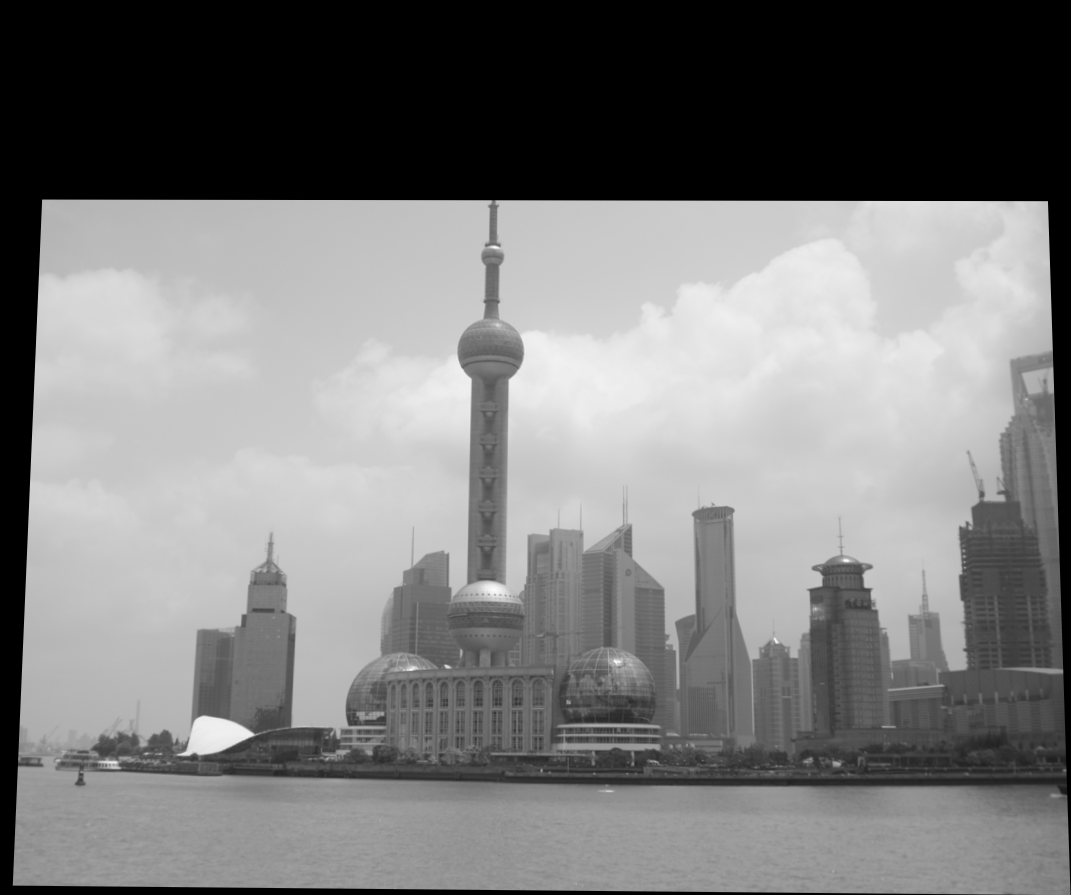

In [ ]:
pano_img1_inverse_warp = inverse_warp(pano_image1_warp,H,pano_image1.shape,pano_image1,min)
cv2_imshow(pano_img1_inverse_warp)

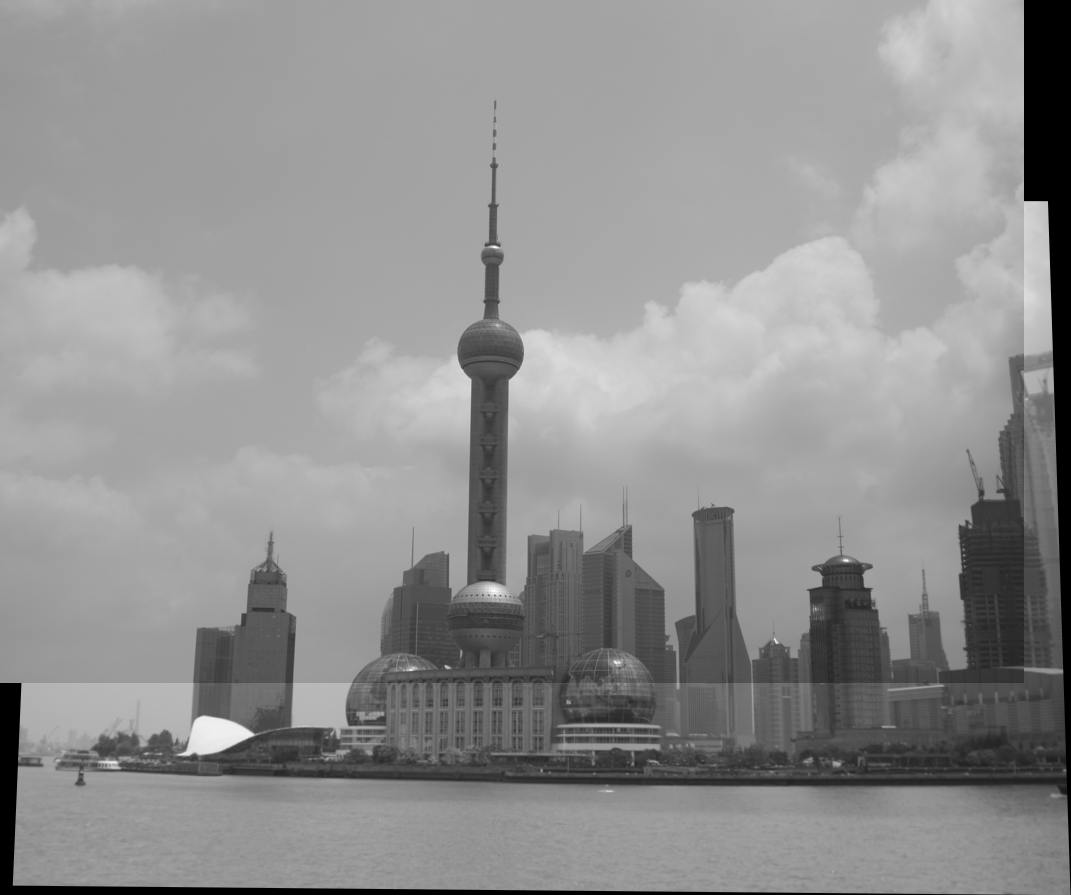

In [ ]:
from PIL import Image
 
# open the image
img = cv2.cvtColor(pano_image2, cv2.COLOR_BGR2RGB)
im2 = Image.fromarray(img)

img2 = cv2.cvtColor(pano_img1_inverse_warp, cv2.COLOR_BGR2RGB)
im1 = Image.fromarray(img2)

x1 = int(0)
x2 = int(min[0])
y1 = int(0)
y2 = int(min[1])
# Work out how many pixels of space we need left, right, above, below common point in new image
pL = max(x1, x2)
pR = max(im1.width-x1,  im2.width-x2)
pT = max(y1, y2)
pB = max(im1.height-y1, im2.height-y2)

# Create background in solid white
bg = Image.new('RGB', (pL+pR, pT+pB),'white')
bg.save('DEBUG-bg.png')

# Paste im1 onto background
bg.paste(im1, (pL-x1, pT-y1))
bg.save('DEBUG-bg+im1.png')

# Make 40% opacity mask for im2
alpha = Image.new('L', (im2.width,im2.height), int(100*255/100))
alpha.save('DEBUG-alpha.png')

# Paste im2 over background with alpha
bg.paste(im2, (pL-x2, pT-y2), alpha)
bg.save('result.png')
cv2_imshow(cv2.imread("/content/result.png"))

image 3 on the result

In [ ]:
pano_image1 = cv2.imread("/content/drive/MyDrive/Assignment2_CV/shanghai-23.png") 
pano_image2 = cv2.imread("/content/result.png")

First images


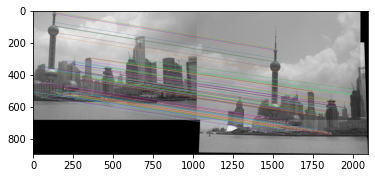

(<matplotlib.image.AxesImage at 0x7f252d5429d0>, None)

In [ ]:
pano_image1_grey = cv2.cvtColor(pano_image1, cv2.COLOR_BGR2GRAY)
pano_image2_grey = cv2.cvtColor(pano_image2, cv2.COLOR_BGR2GRAY)

#sift
sift = cv2.xfeatures2d.SIFT_create()

keypoints_img1, descriptors_img1 = sift.detectAndCompute(pano_image1_grey,None)
keypoints_img2, descriptors_img2 = sift.detectAndCompute(pano_image2_grey,None)

#feature matching
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors_img1,descriptors_img2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.27*n.distance:
        good.append([m])

# cv2.drawMatchesKnn expects list of lists as matches.
out_good_matches = cv2.drawMatchesKnn(pano_image1_grey,keypoints_img1,pano_image2_grey,keypoints_img2,good,pano_image2_grey,flags=2)

print("First images")
plt.imshow(out_good_matches),plt.show()

In [ ]:
correspondenceList = []
for m in good:
  (x1, y1) = keypoints_img1[m[0].queryIdx].pt
  (x2, y2) = keypoints_img2[m[0].trainIdx].pt
  correspondenceList.append([x1, y1, x2, y2])

correspondences = np.matrix(correspondenceList)
H , inliers = RANSAC(correspondenceList,0.7)

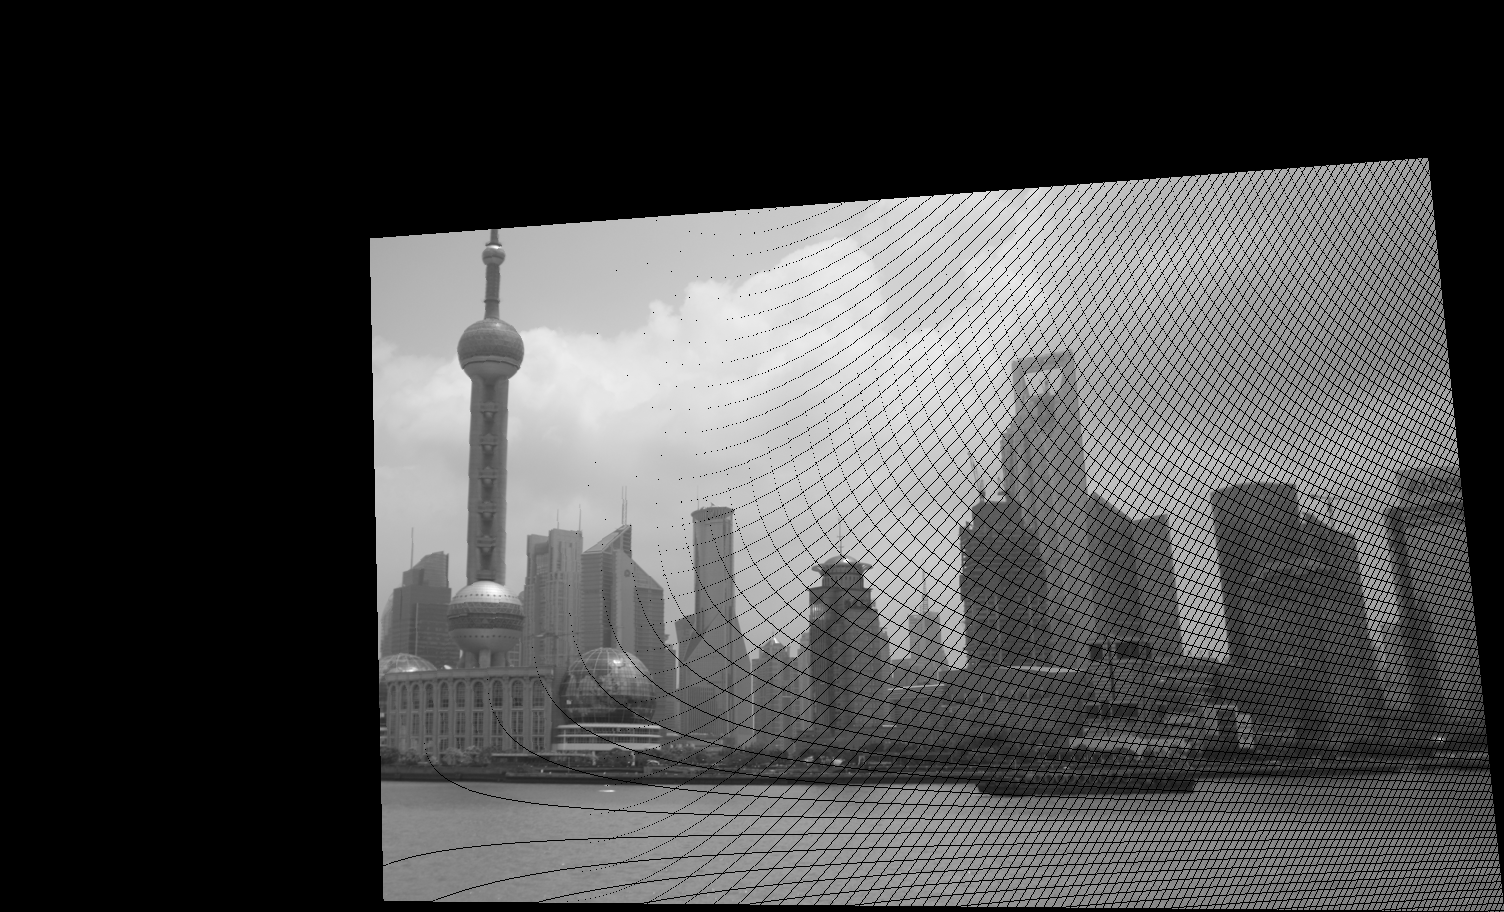

In [ ]:
pano_image1_warp,min = warpImage(H,pano_image1)
cv2_imshow(pano_image1_warp)

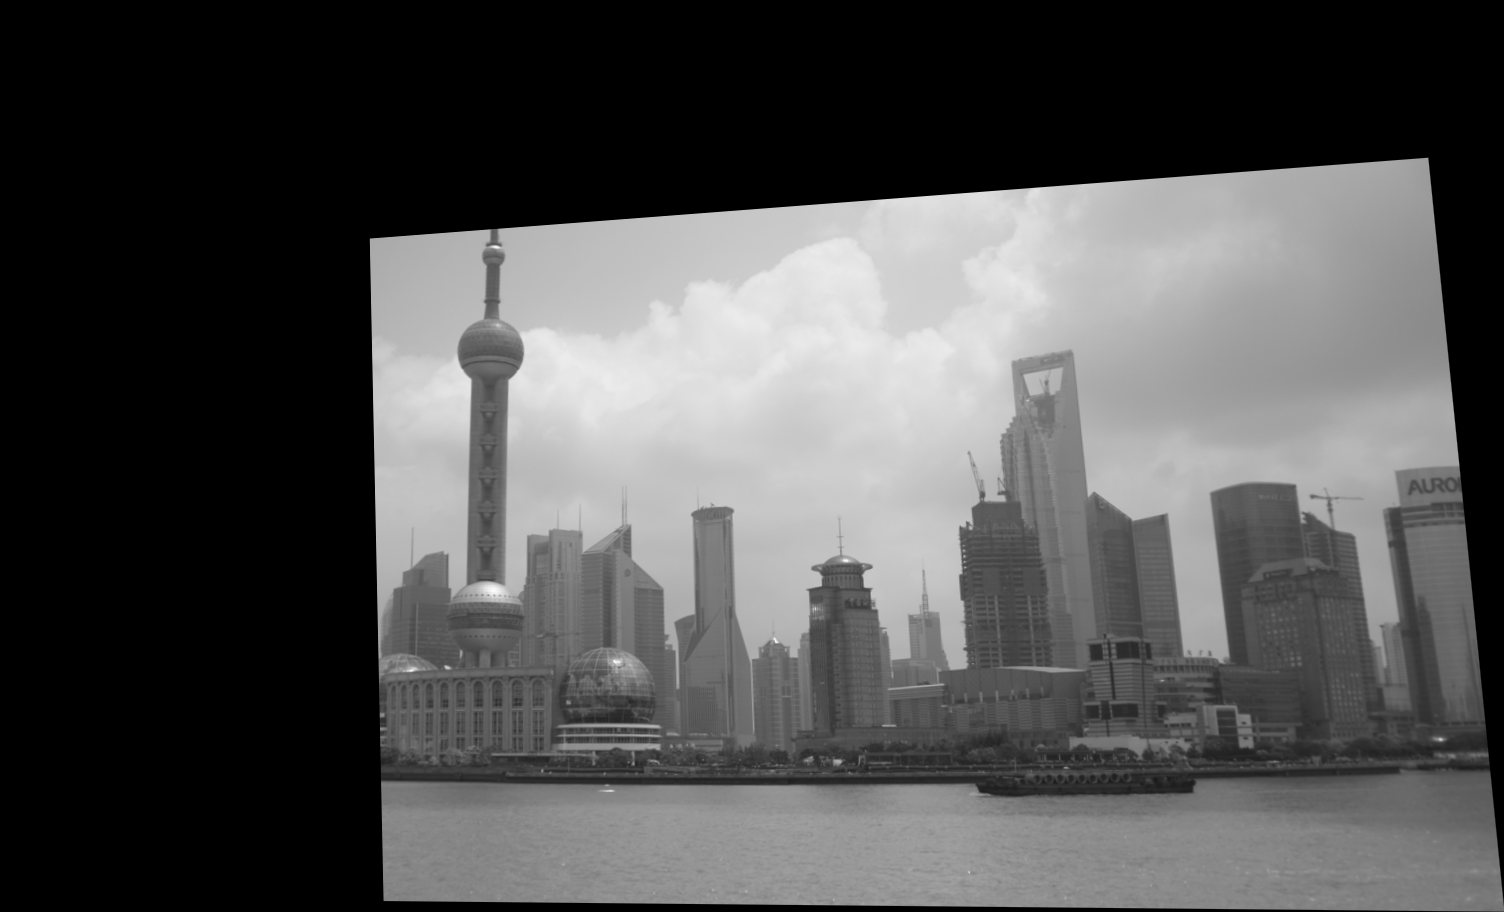

In [ ]:
pano_img1_inverse_warp = inverse_warp(pano_image1_warp,H,pano_image1.shape,pano_image1,min)
cv2_imshow(pano_img1_inverse_warp)

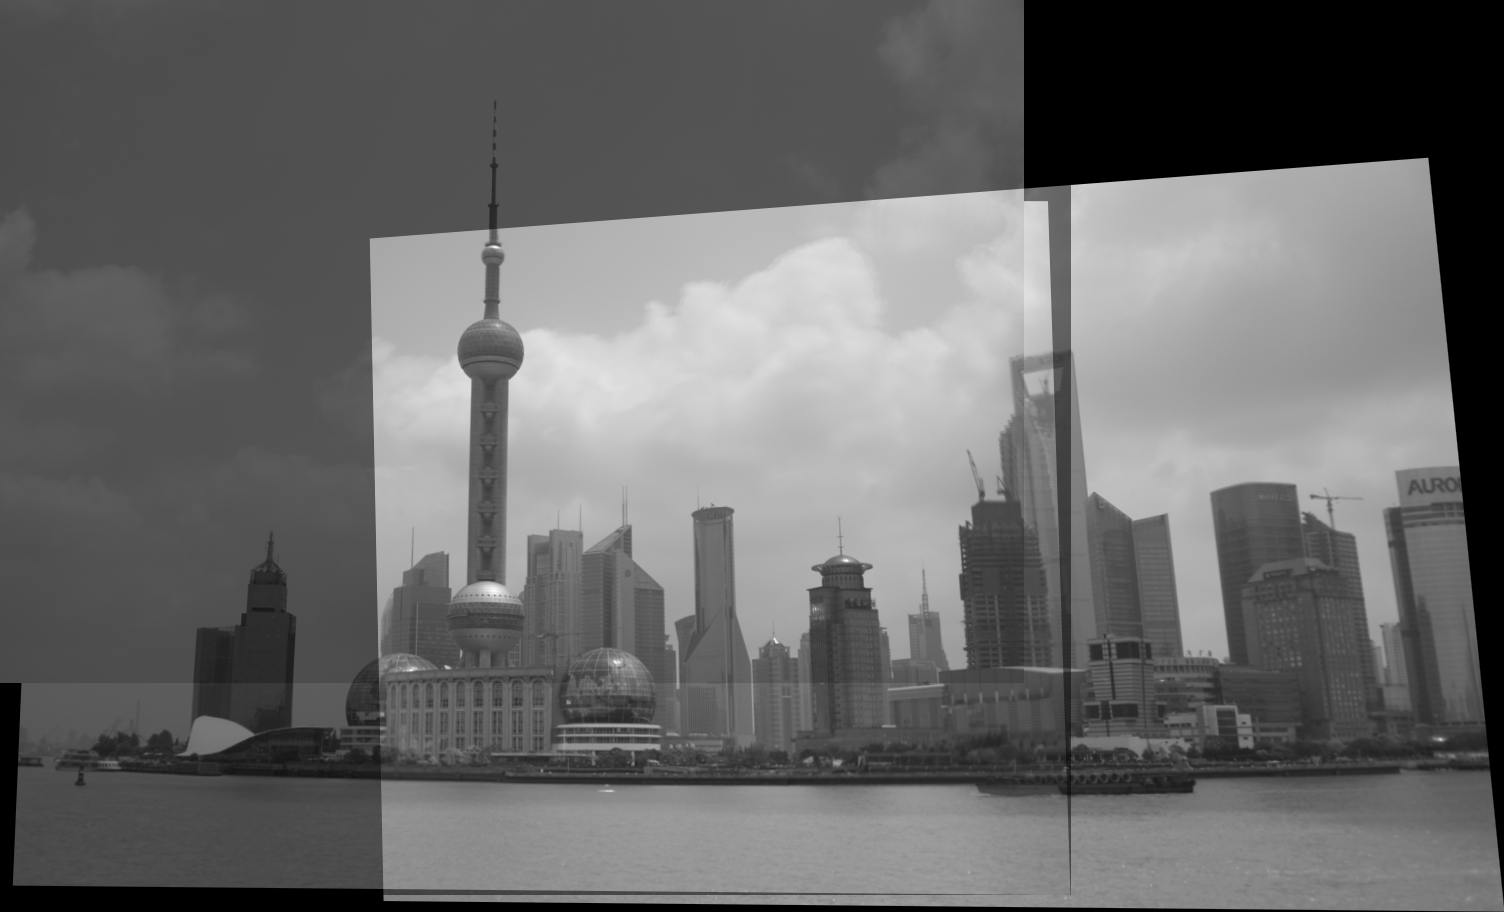

In [ ]:
# open the image
img = cv2.cvtColor(pano_image2, cv2.COLOR_BGR2RGB)
im2 = Image.fromarray(img)

img2 = cv2.cvtColor(pano_img1_inverse_warp, cv2.COLOR_BGR2RGB)
im1 = Image.fromarray(img2)

x1 = int(0)
x2 = int(min[0])
y1 = int(0)
y2 = int(min[1])
# Work out how many pixels of space we need left, right, above, below common point in new image
pL = max(x1, x2)
pR = max(im1.width-x1,  im2.width-x2)
pT = max(y1, y2)
pB = max(im1.height-y1, im2.height-y2)

# Create background in solid white
bg = Image.new('RGB', (pL+pR, pT+pB),'white')
bg.save('DEBUG-bg.png')

# Paste im1 onto background
bg.paste(im1, (pL-x1, pT-y1))
bg.save('DEBUG-bg+im1.png')

# Make 40% opacity mask for im2
alpha = Image.new('L', (im2.width,im2.height), int(50*255/100))
alpha.save('DEBUG-alpha.png')

# Paste im2 over background with alpha
bg.paste(im2, (pL-x2, pT-y2), alpha)
bg.save('result.png')
cv2_imshow(cv2.imread("/content/result.png"))

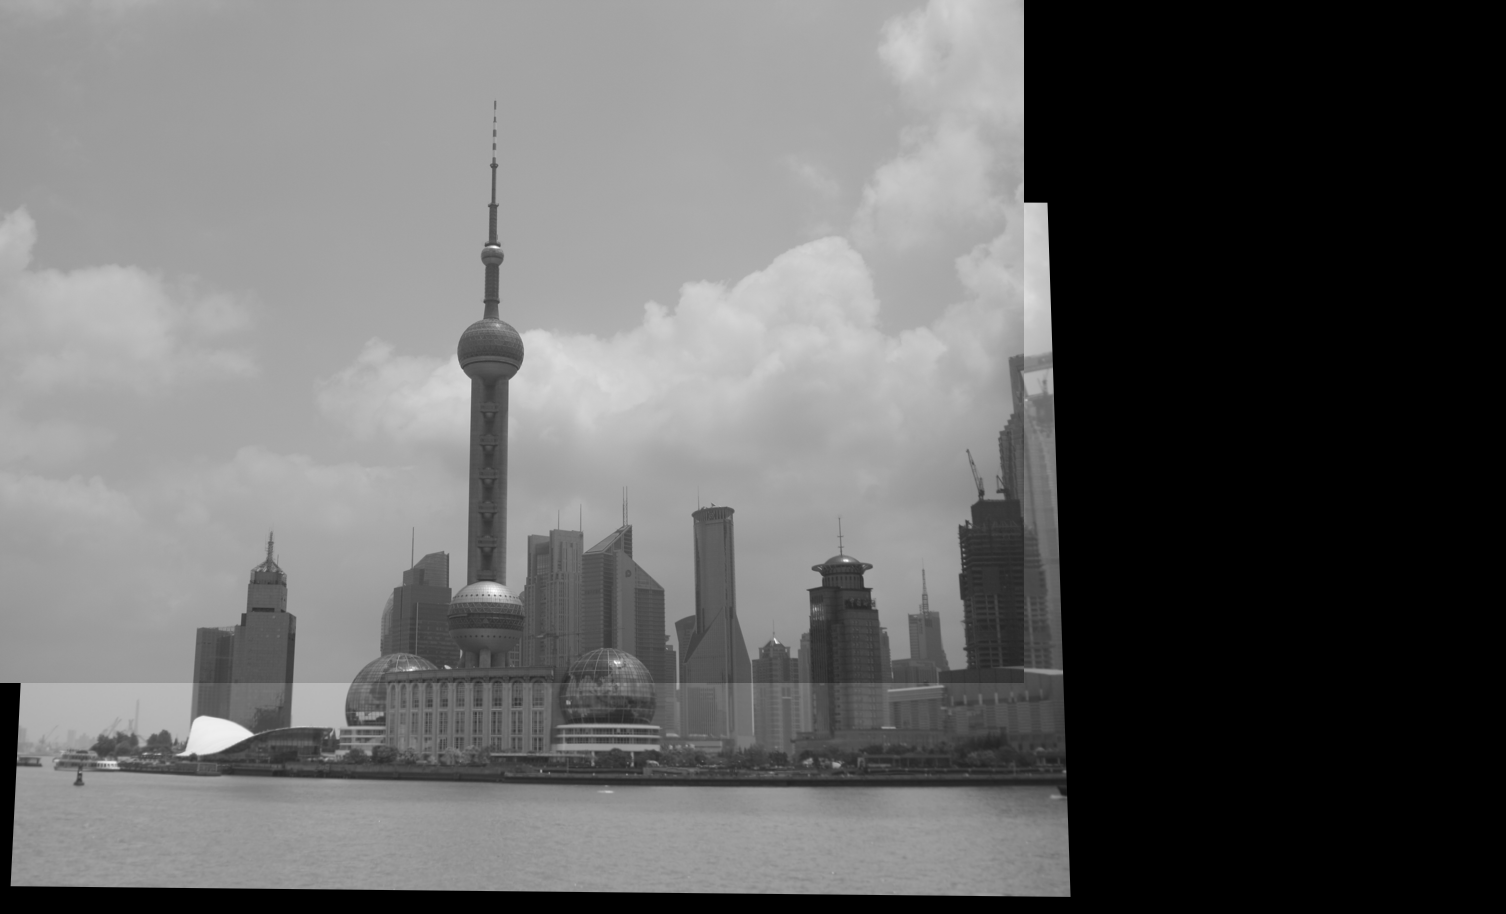

In [ ]:
copy_of_pano_img2 = np.zeros_like(pano_img1_inverse_warp)
cv2.bitwise_not(copy_of_pano_img2)
copy_of_pano_img2[0:pano_image2.shape[0],0:pano_image2.shape[1]]=pano_image2
cv2_imshow(copy_of_pano_img2)

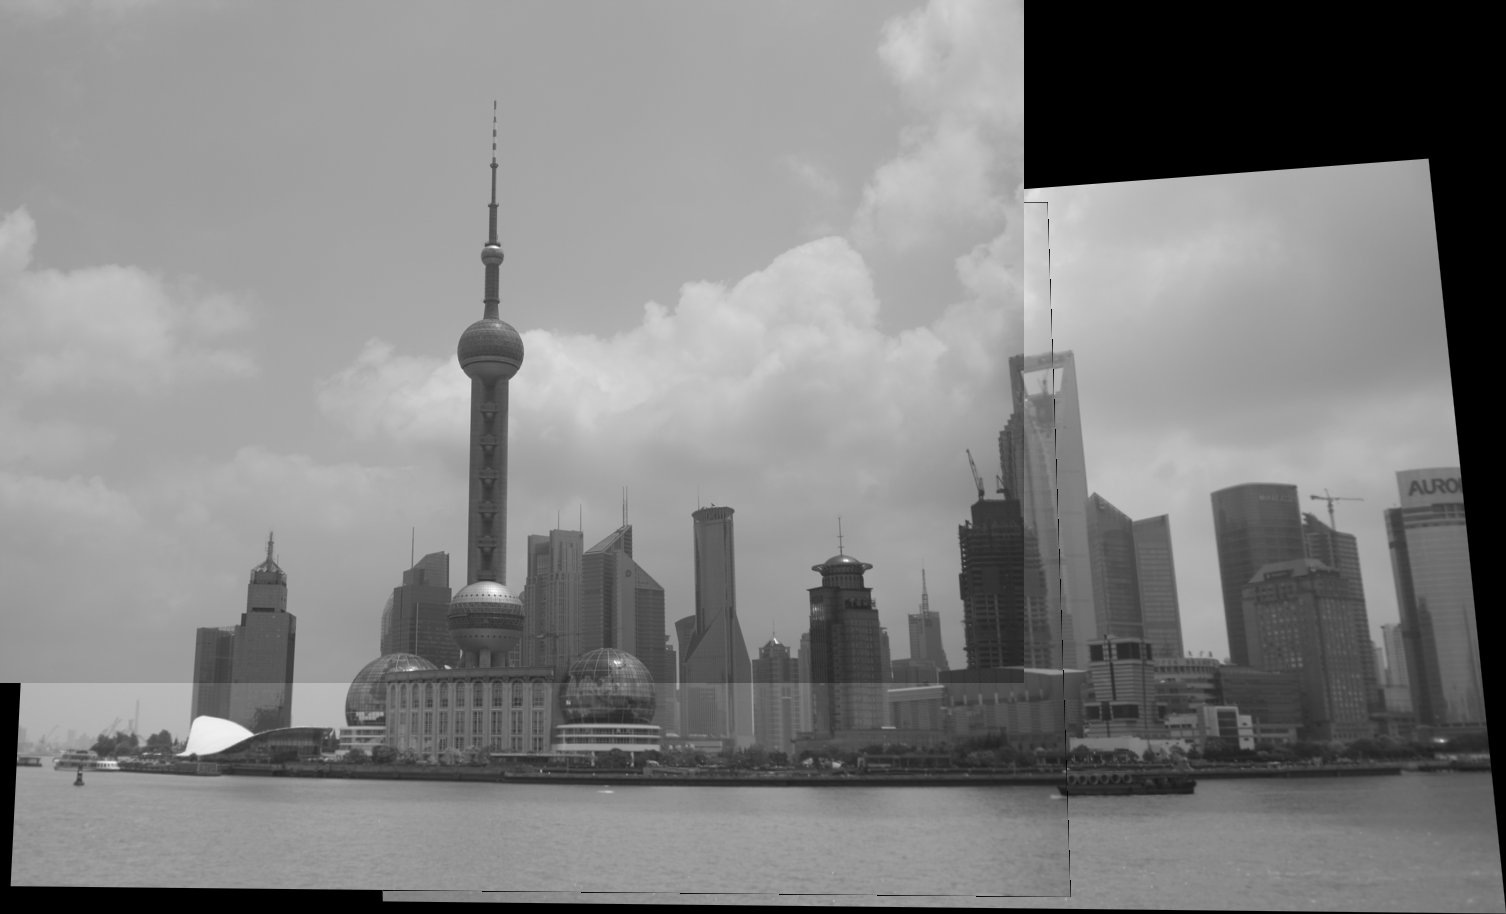

In [ ]:
for i in range(pano_img1_inverse_warp.shape[0]):
  for j in range(pano_img1_inverse_warp.shape[1]):
    if copy_of_pano_img2[i][j][0]==0 and copy_of_pano_img2[i][j][1]==0 and copy_of_pano_img2[i][j][2]==0 :
      copy_of_pano_img2[i][j] = pano_img1_inverse_warp[i][j]

cv2_imshow(copy_of_pano_img2);